In [3]:
# def mask(img_path,model):

#     model.eval()
#     img = Image.open(img_path)
#     final_img = transform(img)

#     final_img= final_img.unsqueeze(0).to(device)

#     mask = model(final_img)
    
#     output = mask > 0.5  
#     output = output.squeeze(0)
#     output = output.permute(1,2,0)
#     plt.imshow(mask)
#     plt.show()
#     return output

In [4]:
# import cv2
# import numpy as np

# # Create a blank image (black)
# image = np.zeros((300, 300, 3), dtype=np.uint8)

# # Define HSV color (H: 0-179, S: 0-255, V: 0-255)
# hsv_color = np.uint8([[[40, 255, 255]]])  # Example: Pure blue in HSV

# # Convert HSV to BGR
# bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]

# # Draw a filled circle
# cv2.circle(image, (150, 150), 25, color=tuple(int(c) for c in bgr_color), thickness=-1)

# # Show the image
# cv2.imshow('HSV Colored Circle', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [5]:
# def region_of_interest2(img ,model,edges):
#     """Isolates the region of interest (ROI)."""
#     """
#     Applies an image mask.
    
#     Only keeps the region of the image defined by the polygon
#     formed from `vertices`. The rest of the image is set to black.
#     """
#     model.eval()
#     final_img = transform(img).to(device)
#     final_img = final_img[:3, :, :]  # Ensure only 3 channels
#     final_img= final_img.unsqueeze(0).to(device)
#     mask = model(final_img)
#     output = mask > 0.5  
#     output = output.squeeze(0)
#     output = output.permute(1,2,0)
#     output = output.numpy()
#     output = output.squeeze(2)
    
#     resized_edges = cv2.resize(edges, (256, 256), interpolation=cv2.INTER_NEAREST)
    
#     edges = (~output) & (resized_edges)
#     plt.imshow(edges)
#     plt.show()
#     return edges 


In [6]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
import torch
import torchvision.models as models
import torch.quantization
import torch.nn as nn
from torchvision import transforms
from models import UNET,transform


In [7]:
device = torch.device('cpu')

In [8]:
model = UNET().to(device)
model.load_state_dict(torch.load(r"segmentation_torch_unet.pth",map_location=torch.device('cpu')))

C:\Users\Mayank\AppData\Local\Temp\ipykernel_35940\1738807017.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"segmentation_torch_unet.

<All keys matched successfully>

In [9]:

def gaussian_show(std,kernel_size,image_path):

  """
  gaussian blurring is helpful in denoising images and in reducing noise
  """

  image = cv2.imread(image_path)
  # image = cv2.resize(image, (201, 256))  # (width, height)
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  blur = cv2.GaussianBlur(rgb_image, (kernel_size, kernel_size), std)
  return blur

In [10]:
def color_mask(frame):
    
    """Applies a color mask to isolate white and yellow lanes."""
    
    # hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # # Define color rang 
    # e for yellow
    # yellow_mask = cv2.inRange(hsv, np.array([20, 150, 150]), np.array([35, 255, 255]))

    # # Define color range for white (this part seems fine)
    # white_mask = cv2.inRange(hsv, np.array([0, 0, 185]), np.array([180, 40, 255]))

    # combined_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    # final_mask = cv2.bitwise_and(frame, frame, mask=combined_mask)  
    # # plt.imshow(final_mask)
    # # plt.show()
    print(max([max(x) for x in cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)]))
    output = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
    edges = np.where(output >= 230, 1, 0)
    return edges



In [11]:
def adaptive_color_mask(image):
    """Enhances lane colors using LAB color space and adaptive thresholding"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Adaptive threshold based on brightness (L-channel)
    _, binary_l = cv2.threshold(l_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Mask yellow (b-channel) and white lanes (l-channel)
    yellow_mask = cv2.inRange(b, 120, 255)  # Yellow lanes are in the b-channel
    white_mask = binary_l  # White lanes are bright in L-channel

    final_mask = cv2.bitwise_or(yellow_mask, white_mask)
    return final_mask
def enhance_contrast(image):
    """Applies CLAHE to improve lane visibility under different lighting conditions"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l)

    enhanced_lab = cv2.merge([enhanced_l, a, b])
    enhanced_bgr = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    return enhanced_bgr
def adaptive_canny_edge_detection(image, sigma=0.33):
    """Applies Canny edge detection with adaptive thresholding based on image statistics."""
    if len(image.shape) == 3:  # Convert to grayscale if needed
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    v = np.median(gray)  # Compute median pixel intensity
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))

    edges = cv2.Canny(gray, lower, upper)
    return edges
def remove_noise(edges):
    """Removes noise using morphological operations"""
    kernel = np.ones((3,3), np.uint8)
    clean_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)  # Fill gaps
    clean_edges = cv2.morphologyEx(clean_edges, cv2.MORPH_OPEN, kernel)  # Remove small noise
    return clean_edges


In [12]:
def region_of_interest(img, model, edges, color_mask):
    """Isolates the region of interest (ROI)."""
    model.eval()
    final_img = transform(img).to(device)
    final_img = final_img[:3, :, :]  # Ensure only 3 channels
    final_img = final_img.unsqueeze(0).to(device)
    
    maskk = model(final_img)
    output = maskk > 0.5  
    output = output.squeeze(0).permute(1, 2, 0).numpy().squeeze(2)
    
    plt.imshow(~output, cmap="gray")
    plt.show()

    resized_edges = cv2.resize(color_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    # resized_edges = cv2.cvtColor(resized_edges, cv2.COLOR_BGR2GRAY)

    # Initialize edges array
    edges = np.where(output.astype(int) == 0, resized_edges, 0)

    print(edges.shape)
    plt.imshow(edges, cmap="gray")
    plt.show()

    return edges


Processing PXL_20250227_093632544.jpg...


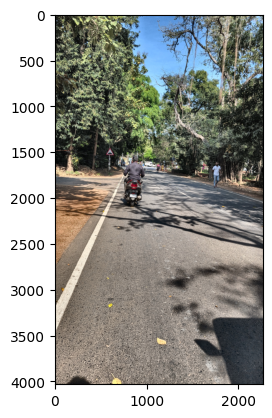

255


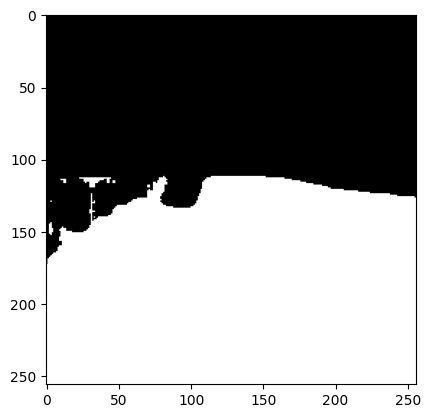

(256, 256)


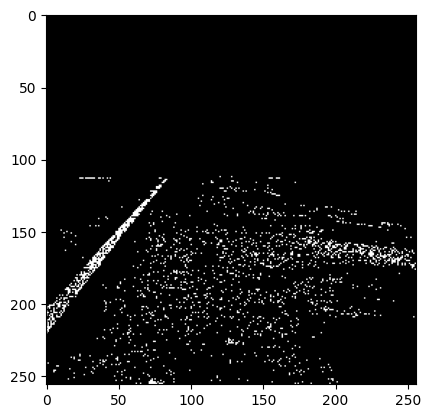

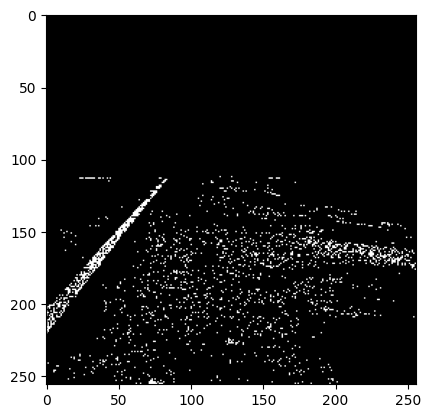

Processing PXL_20250227_093640024.jpg...


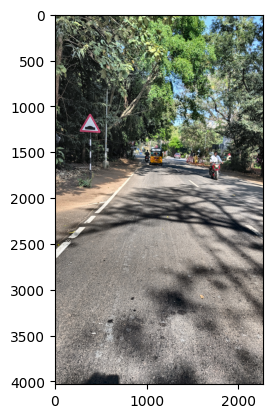

255


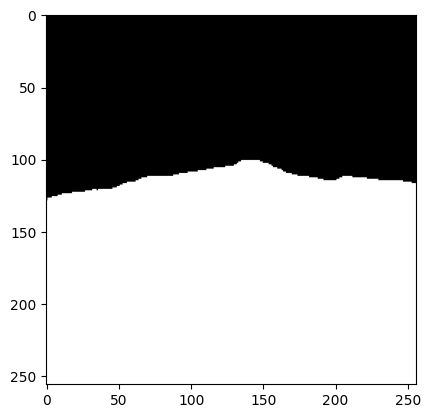

(256, 256)


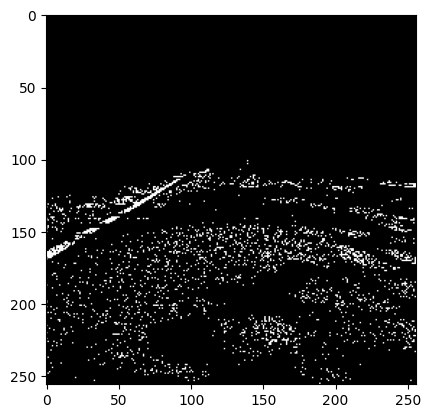

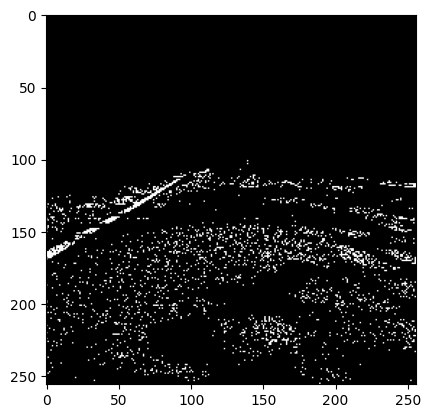

Processing PXL_20250227_093653356.jpg...


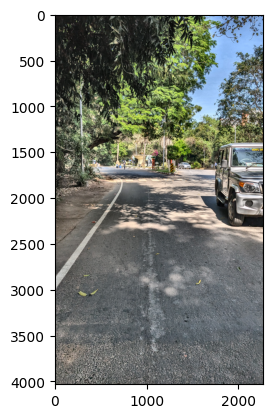

255


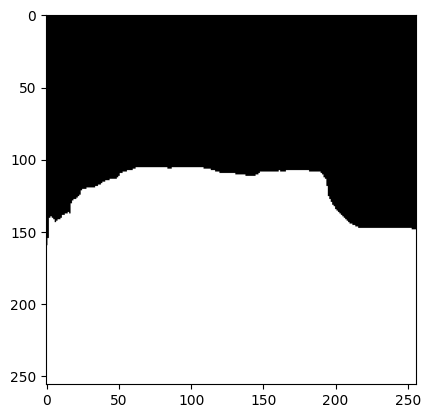

(256, 256)


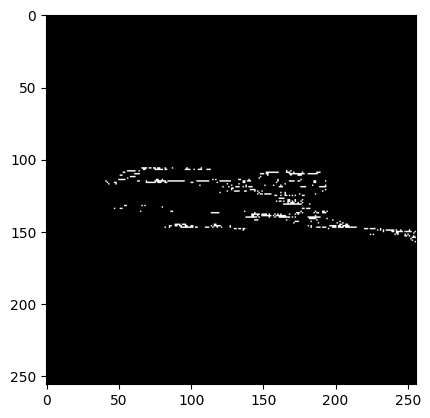

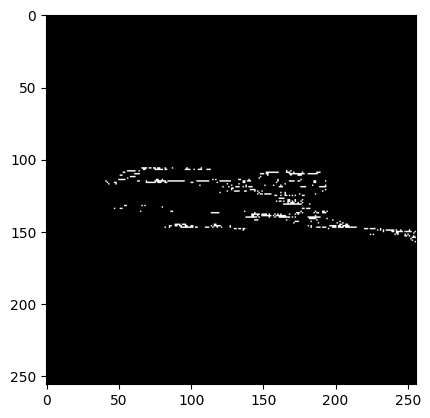

Processing PXL_20250227_093731924.jpg...


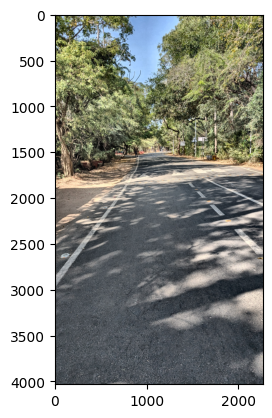

255


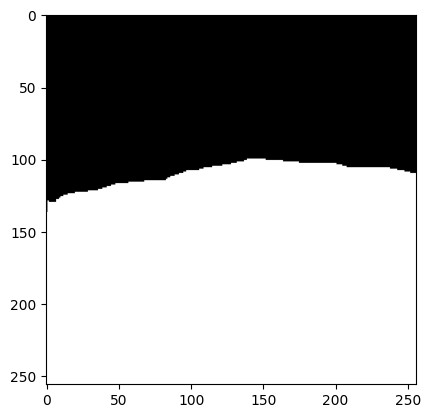

(256, 256)


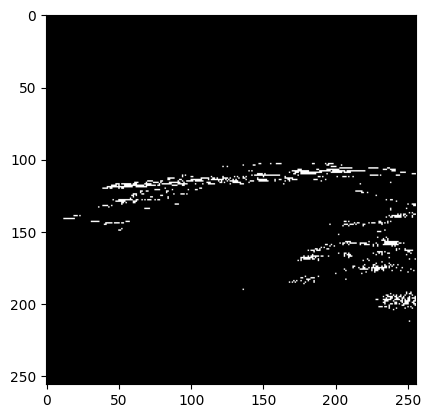

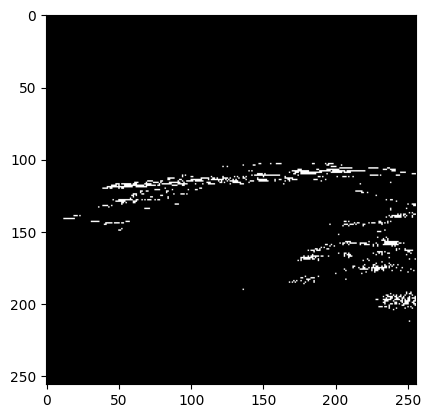

Processing PXL_20250227_093733280.jpg...


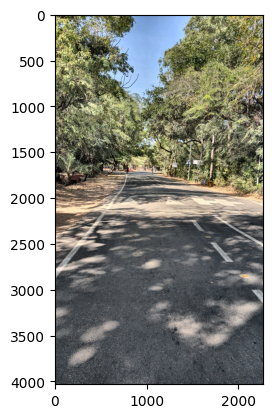

255


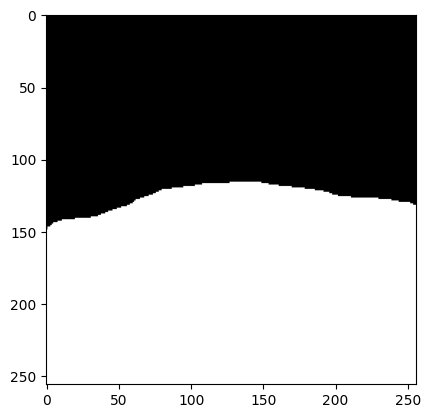

(256, 256)


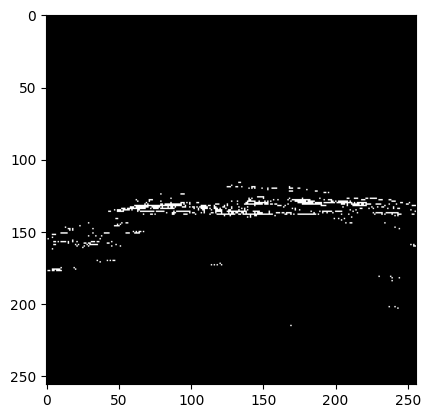

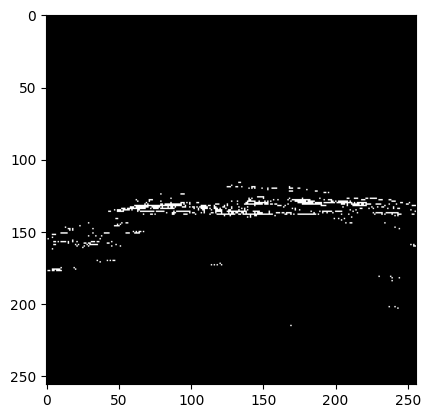

Processing PXL_20250227_093750088.jpg...


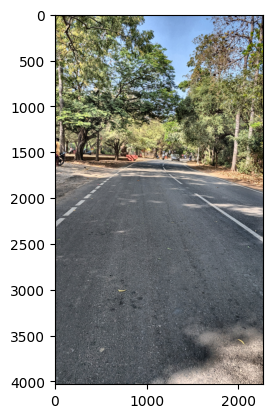

255


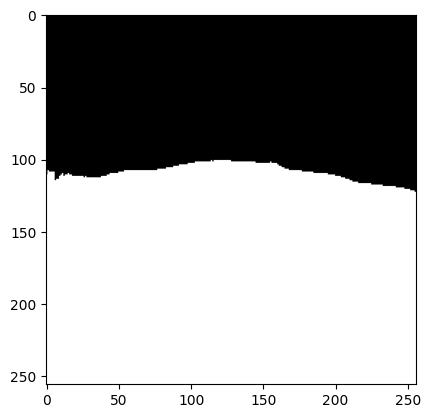

(256, 256)


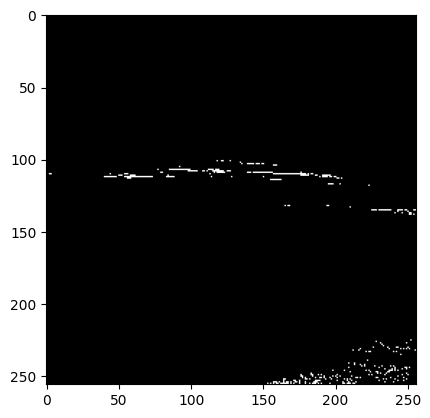

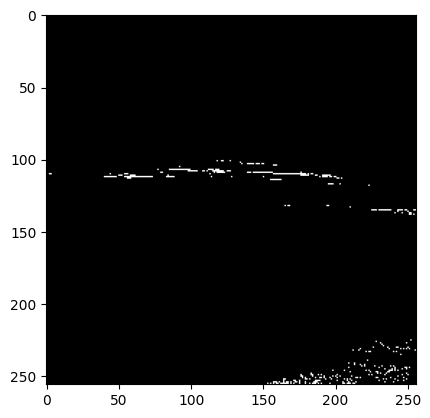

Processing PXL_20250227_093837130.jpg...


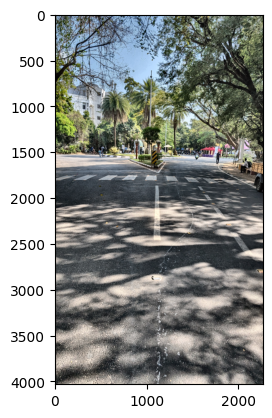

255


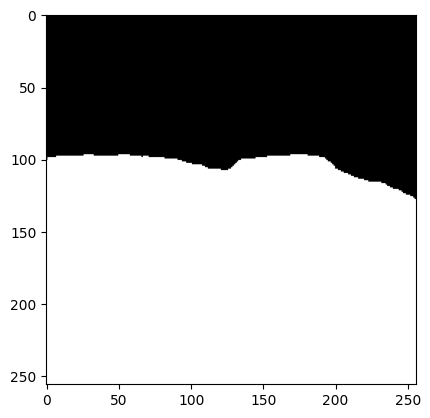

(256, 256)


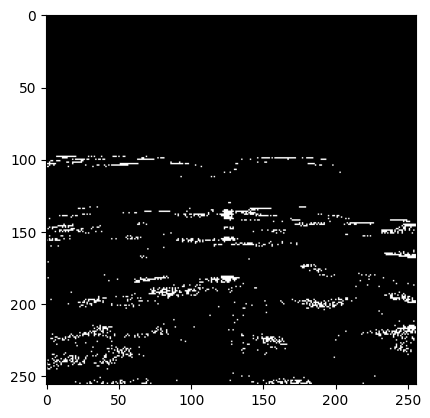

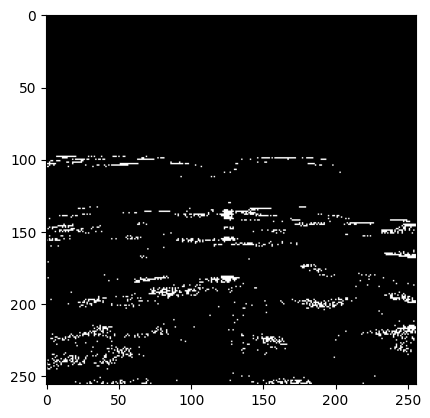

Processing PXL_20250227_093840406.jpg...


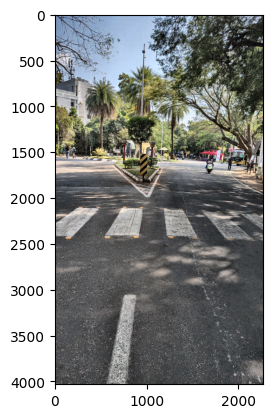

255


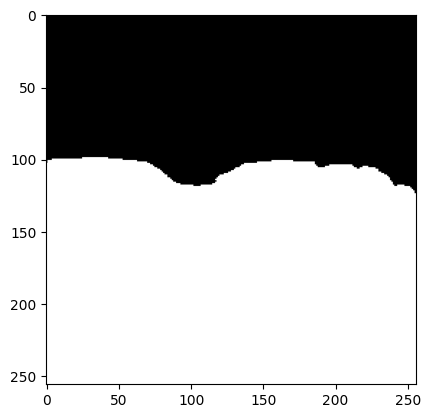

(256, 256)


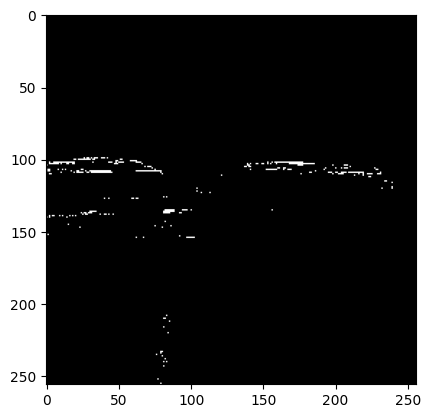

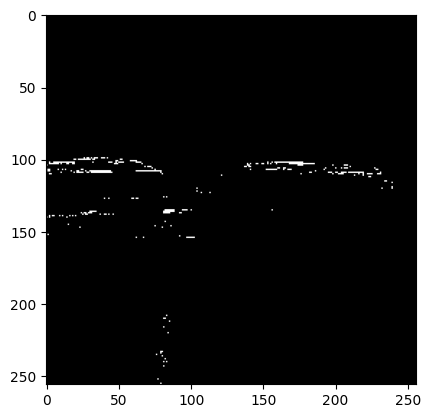

Processing PXL_20250227_093840976.jpg...


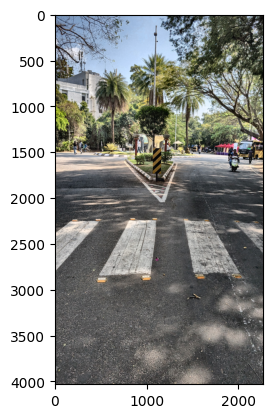

255


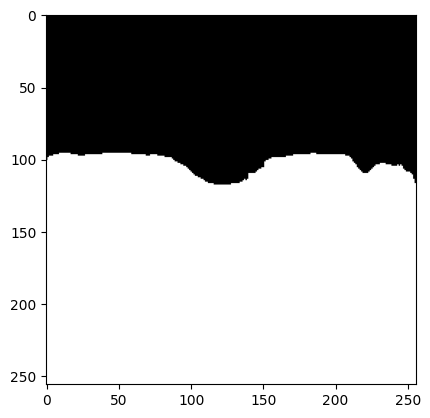

(256, 256)


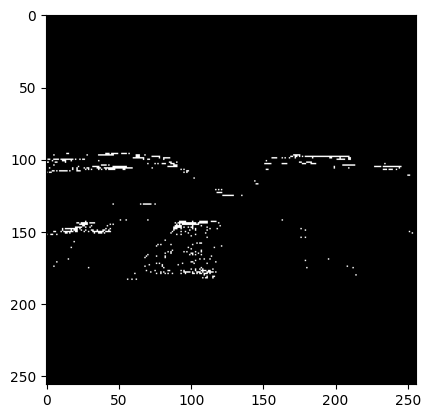

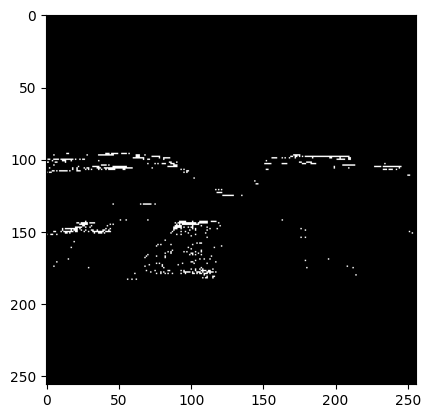

Processing PXL_20250227_093953277.jpg...


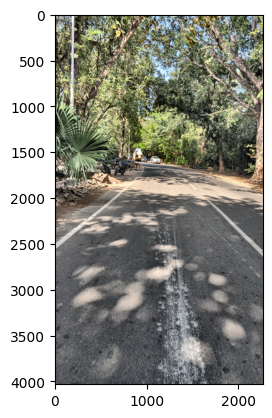

255


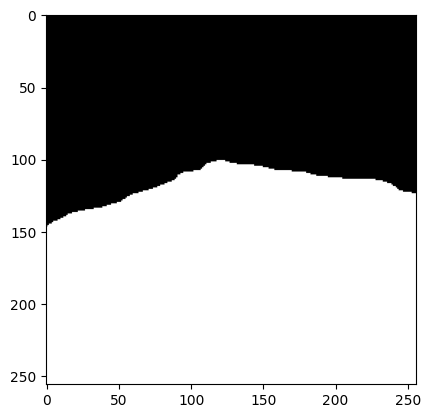

(256, 256)


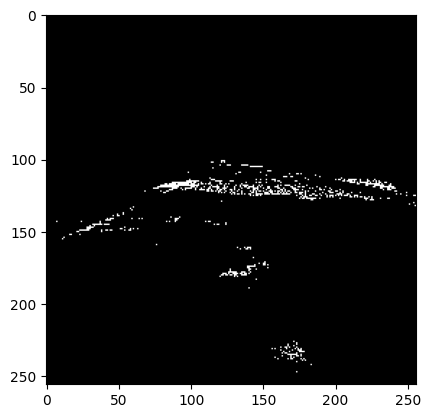

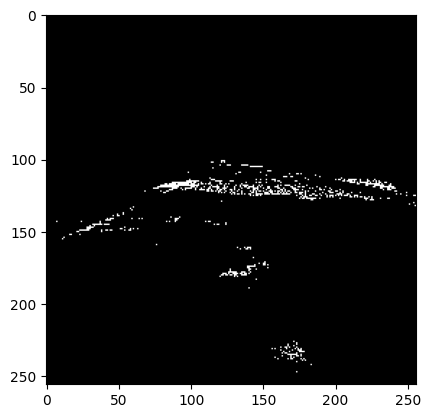

Processing PXL_20250227_093956418.jpg...


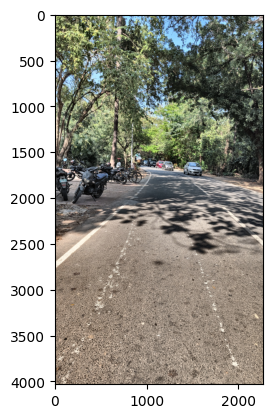

255


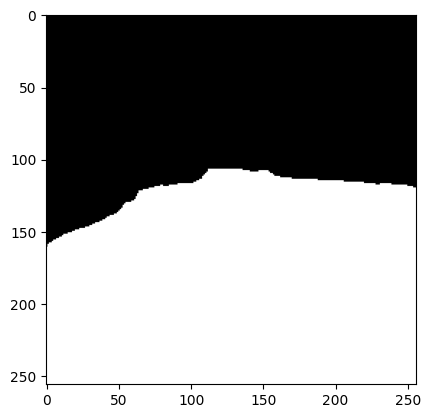

(256, 256)


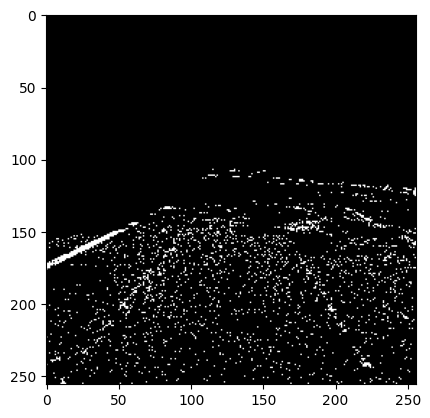

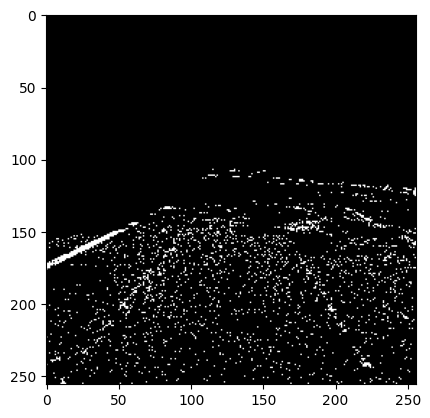

Processing PXL_20250227_094021527.jpg...


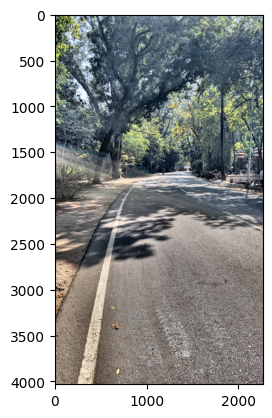

255


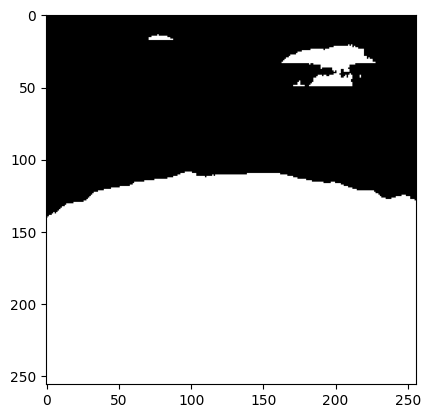

(256, 256)


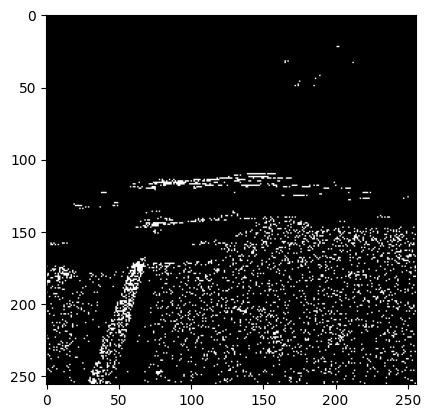

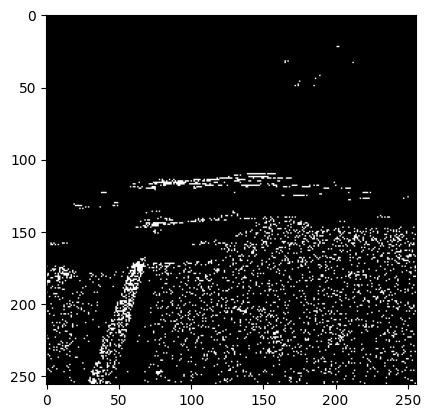

Processing PXL_20250227_094045135.jpg...


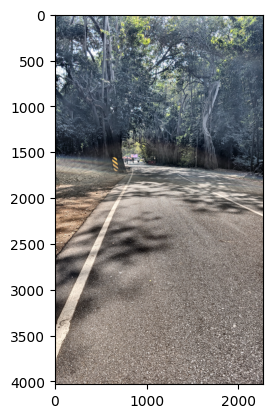

255


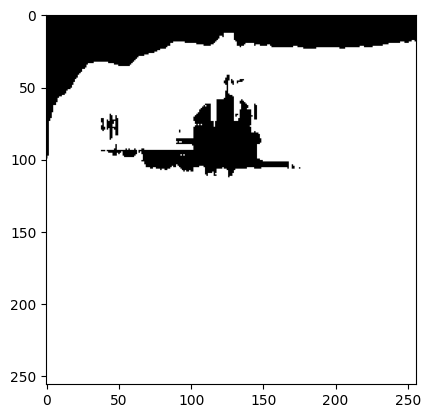

(256, 256)


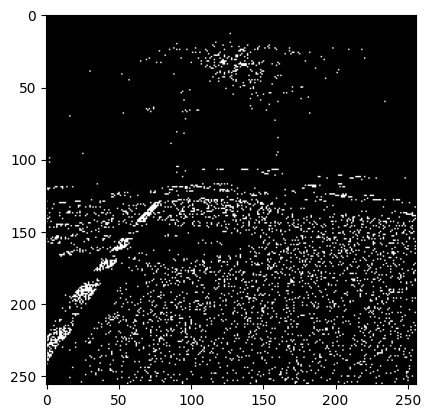

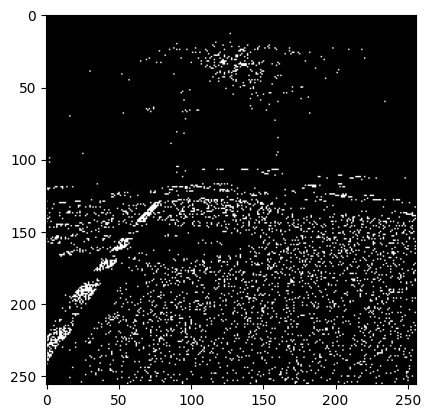

Processing PXL_20250227_094239799.jpg...


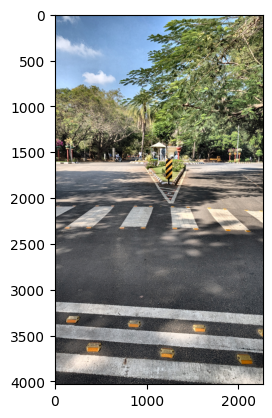

255


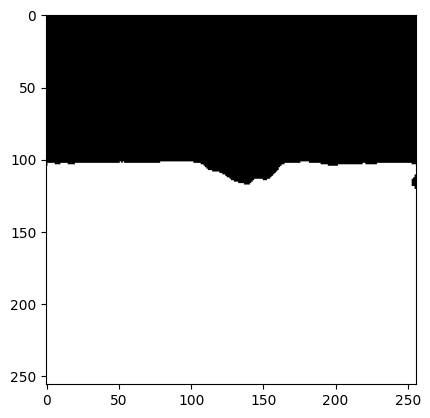

(256, 256)


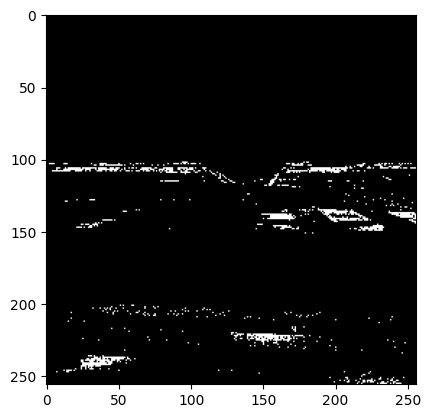

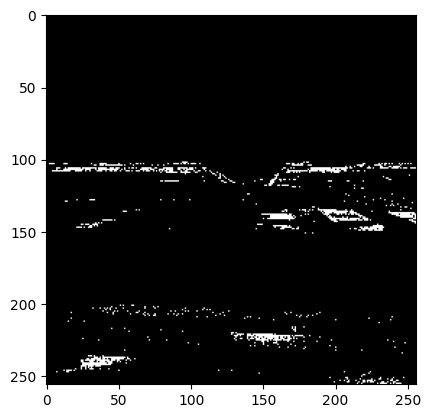

Processing PXL_20250227_094242202.jpg...


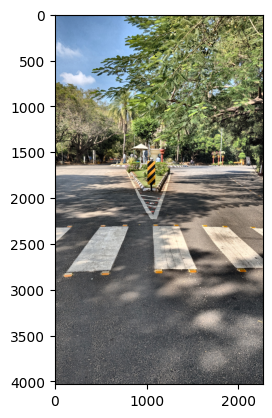

255


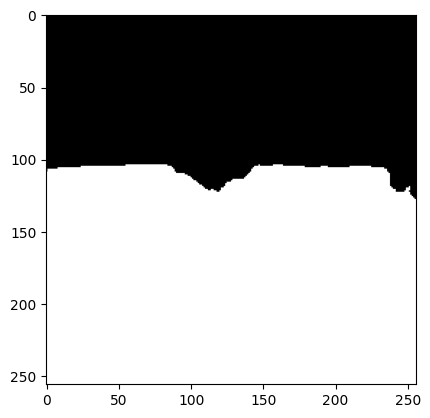

(256, 256)


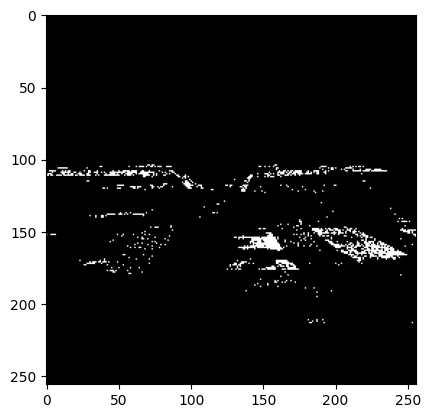

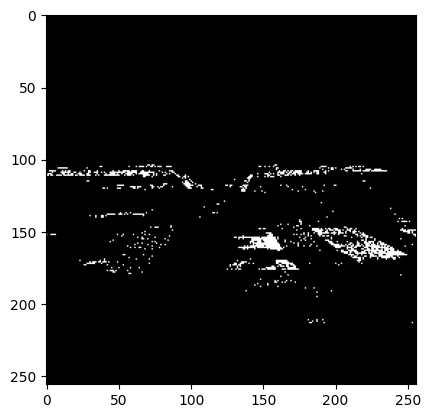

Processing PXL_20250227_094245136.jpg...


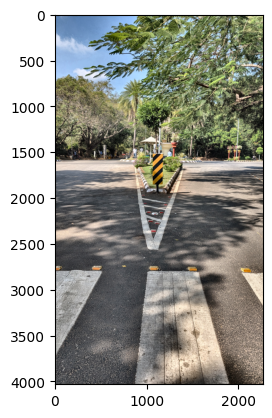

255


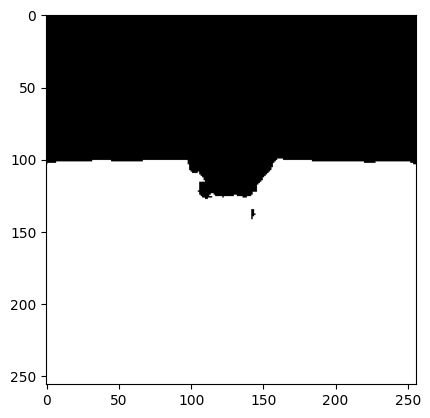

(256, 256)


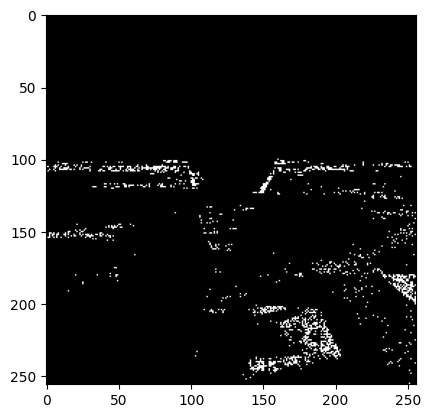

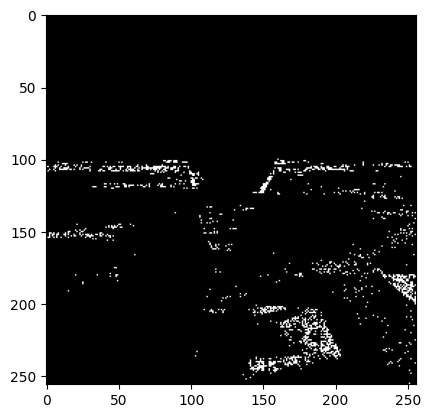

Processing PXL_20250227_094246900.jpg...


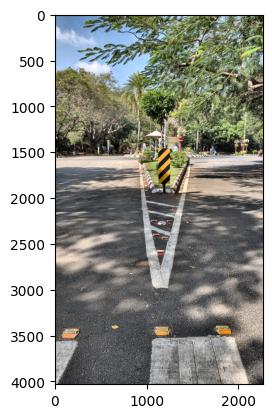

255


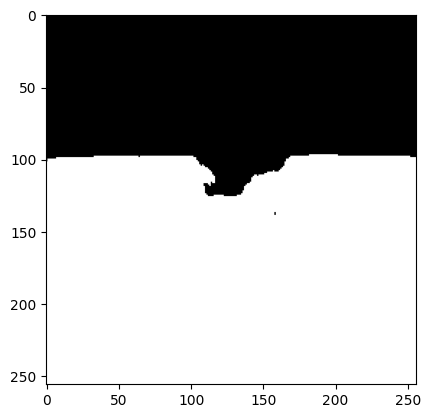

(256, 256)


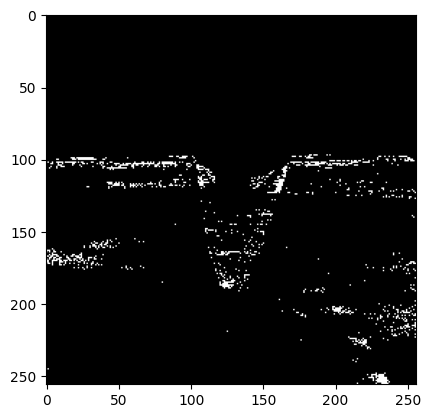

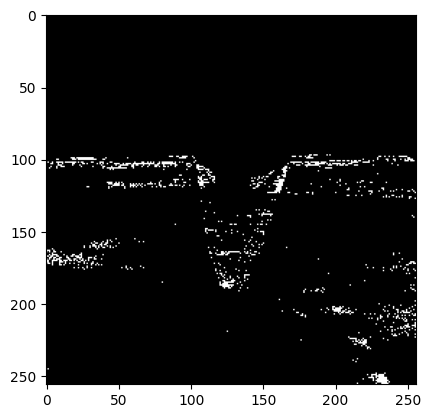

Processing road_at_night_202281.jpg...


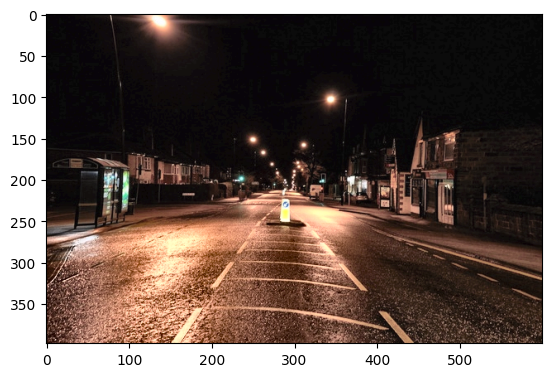

255


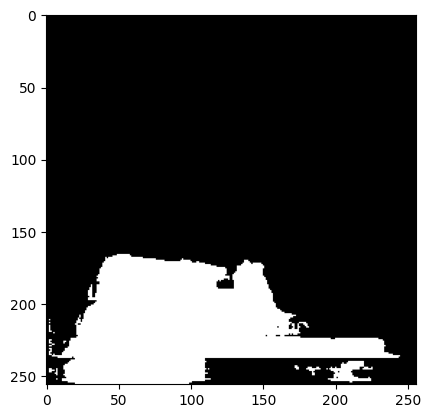

(256, 256)


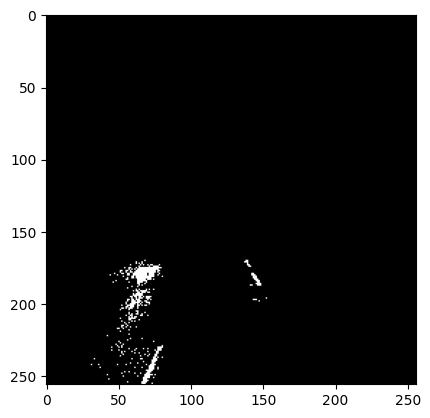

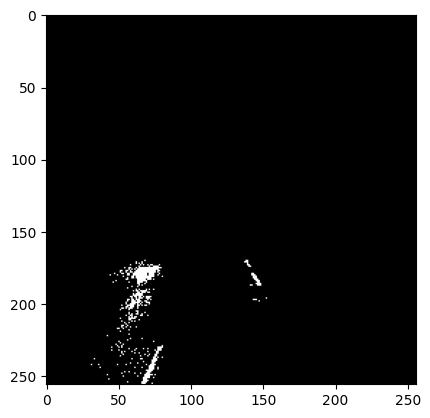

Processing solidWhiteCurve.jpg...


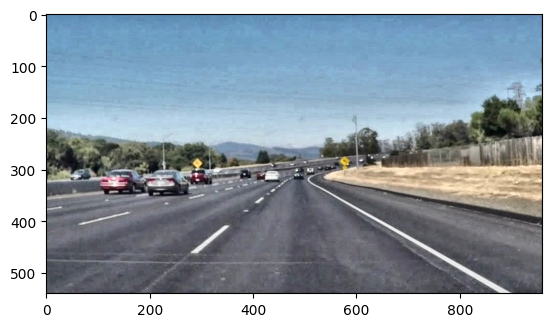

255


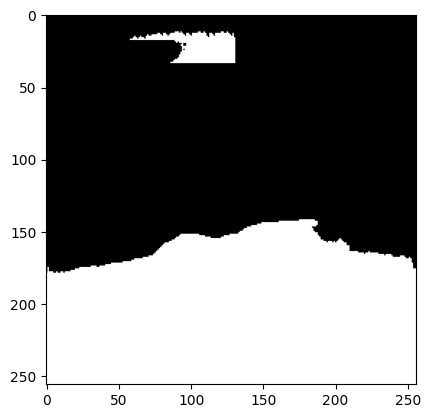

(256, 256)


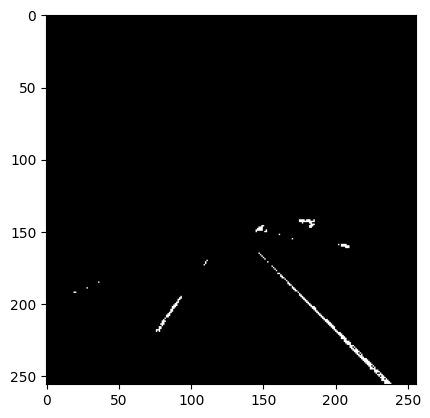

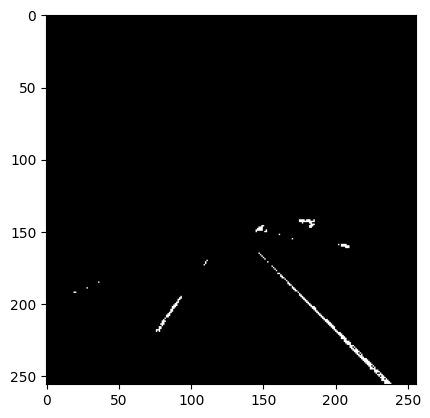

Processing ssht.png...


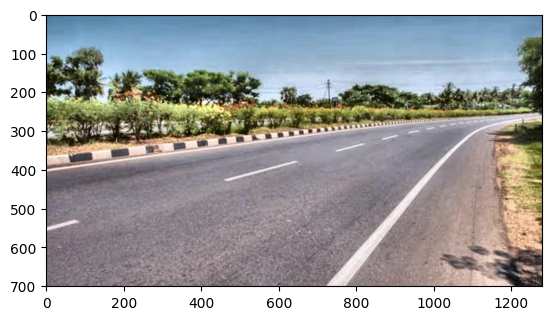

253


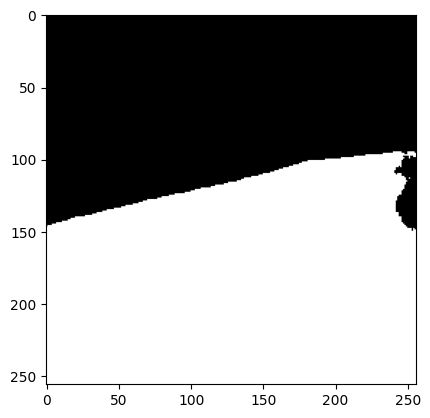

(256, 256)


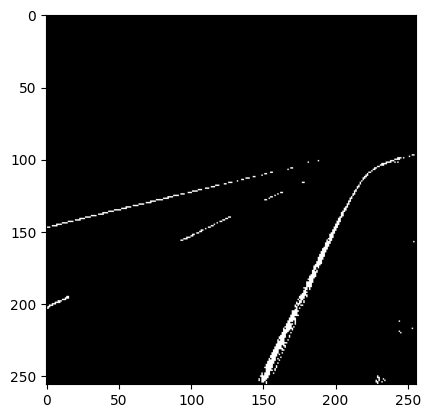

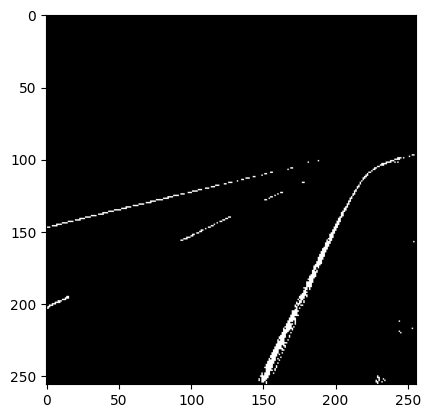

Processing stockimg.jpg...


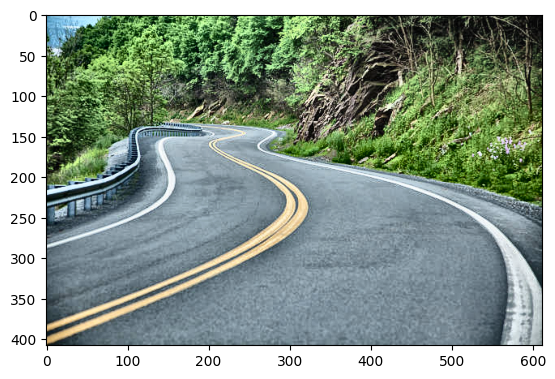

255


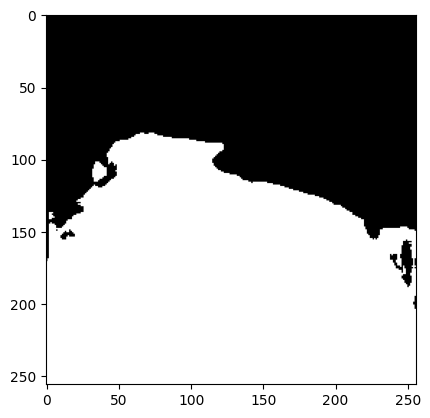

(256, 256)


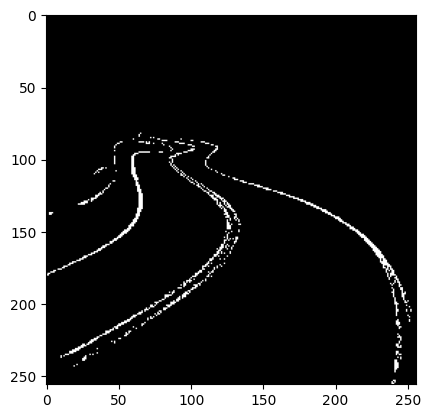

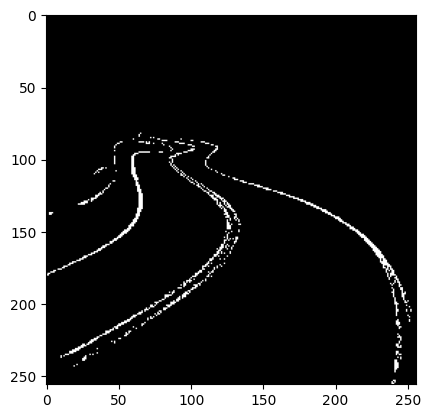

In [13]:
input_folder = "./test_images"
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for image_name in image_files:
    image_path = os.path.join(input_folder, image_name)
    print(f"Processing {image_name}...")

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Enhance contrast for better lane visibility
    enhanced_img = enhance_contrast(img)
    plt.imshow(enhanced_img, cmap = 'gray')
    plt.show()
    # enhanced_img = cv2.blur(enhanced_img, (35, 35))
    colormsk = color_mask(enhanced_img)
    # plt.imshow(colormsk,cmap="gray")
    # plt.show()
    
    no_sky = region_of_interest(Image.fromarray(img),model,Image.fromarray(enhanced_img),colormsk)
    plt.imshow(no_sky, cmap = "gray")
    plt.show()

    # Perform adaptive Canny edge detection
    # edge_detected_image = adaptive_canny_edge_detection(colormsk)
    # plt.imshow(edge_detected_image, cmap='gray')
    # plt.show()

    # # Remove noise using morphological operations
    # clean_edges = remove_noise(edge_detected_image)
    # plt.imshow(clean_edges, cmap='gray')
    # plt.show()



In [14]:
import numpy as np
import cv2
import torch
from PIL import Image
from models import UNET, transform
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load model once
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET().to(device)
model.load_state_dict(torch.load(r"C:\Users\Mayank\Desktop\Lane_det\segmentation_torch_unet.pth", map_location=device, weights_only=True))
model.eval()

# Function to ensure image is RGB
def ensure_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[2] == 3 else image

# Get segmentation mask from model
def get_segmentation_mask(frame):
    try:
        frame_rgb = ensure_rgb(frame)
        img = Image.fromarray(frame_rgb)
        final_img = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            mask = model(final_img)
        
        output = (mask > 0.5).squeeze(0).permute(1, 2, 0).cpu().numpy()
        return output
    except Exception as e:
        print(f"Error in segmentation mask: {e}")
        return np.ones((frame.shape[0], frame.shape[1]))

# Adaptive Canny Edge Detection
def adaptive_canny(frame):
# try:
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    gray = np.where(gray >= 230, 1, 0)
    print(gray.shape)
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    edges = cv2.Canny(gray, threshold * 0.75, threshold)
    print(edges.shape)
    plt.imshow(edges,cmap="gray")
    plt.show()
    return edges
    # except Exception as e:
    #     print("hi")
    #     print(f"Error in Canny edge detection: {e}")
    #     width,height,_=frame.shape
    #     return np.zeros((width,height))

# Dynamic Hough Line Transform
def detect_hough_lines(edges):
    try:
        minLineLength = max(50, edges.shape[0] // 10)
        maxLineGap = max(20, edges.shape[1] // 20)
        plt.imshow(cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=minLineLength, maxLineGap=maxLineGap),cmap="gray")
        plt.show()
        return cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=minLineLength, maxLineGap=maxLineGap)
    except Exception as e:
        print(f"Error in Hough Line detection: {e}")
        return None

def split_lines(lines):
    left_lines, right_lines = [], []
    
    if lines is None:  # Handle None or empty input safely
        print("Warning: No lines detected!")
        return left_lines, right_lines

    x_coords = [line[0][0] for line in lines]  # Extract x1 values

    if x_coords is None:  # Ensure x_coords is not empty
        print("Warning: No valid x-coordinates found!")
        return left_lines, right_lines
    
    x_coords.sort()  # Sort in place
    xmid = x_coords[len(x_coords) // 2]  # Find the middle x-value

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 <= xmid:
            left_lines.append(line)
        else:
            right_lines.append(line)

    return left_lines, right_lines


# Fit a single line for each lane

def cluster_lines(lines, k_val=1):
    if lines is None or len(lines) == 0:
        print(" Warning: No lines found for clustering!")
        return []  # Return an empty list instead of causing an error

    line_features = np.array([
        [(x1 + x2) / 2, (y1 + y2) / 2, np.arctan2(y2 - y1, x2 - x1)] 
        for [[x1, y1, x2, y2]] in lines
    ])
        
    # Ensure at least k clusters exist
    k_val = min(k_val, len(lines))  # Prevent k > number of data points

    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init=10).fit(line_features)
    labels = kmeans.labels_

    clustered_lines = [
        [[int(np.mean([lines[i][0][j] for i in np.where(labels == idx)[0]])) for j in range(4)]]
        for idx in range(k_val)
    ]
    return clustered_lines


# Lane detection pipeline
def lane_detection_pipeline(frame):
    try:
        frame_rgb = ensure_rgb(frame)
        blurred_frame = cv2.GaussianBlur(frame_rgb, (5,5), 1)
        mask = get_segmentation_mask(frame)
        edges = adaptive_canny(blurred_frame)
        mask_resized = cv2.resize(mask.astype(np.uint8), (edges.shape[1], edges.shape[0]), interpolation=cv2.INTER_NEAREST)
        inverted_mask = 1 - mask_resized
        edges = edges * inverted_mask
        lines = detect_hough_lines(edges)
        left_lines, right_lines = split_lines(lines, frame.shape[1])
        left_lane = cluster_lines(left_lines)
        right_lane = cluster_lines(right_lines)
        return [left_lane, right_lane]
    except Exception as e:
        print(f"Error in lane detection pipeline: {e}")
        return [None, None]

# Draw lanes
def draw_lanes_and_arrow(frame, lines):
    try:
        if lines is None or len(lines) < 2:
            print("Not enough lines to draw midline arrow!")
            return frame

        # Draw individual lane lines
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Compute midline coordinates
        x_start = (lines[0][0][0] + lines[1][0][0]) // 2  # (x1 of first + x1 of second) / 2
        y_start = (lines[0][0][1] + lines[1][0][1]) // 2  # (y1 of first + y1 of second) / 2
        x_end = (lines[0][0][2] + lines[1][0][2]) // 2  # (x2 of first + x2 of second) / 2
        y_end = (lines[0][0][3] + lines[1][0][3]) // 2  # (y2 of first + y2 of second) / 2

        # Draw the midline arrow
        cv2.arrowedLine(frame,  (x_start, y_start),(x_end, y_end),(0, 0, 255), 3, tipLength=0.3)

        return frame  # Return modified frame

    except Exception as e:
        print(f"Error in drawing lanes: {e}")
        return frame  # Return original frame if error

def process_frame(frame):

    frame_rgb = ensure_rgb(frame)
    blurred_frame = cv2.GaussianBlur(frame_rgb, (5,5), 1)
    mask = get_segmentation_mask(frame)
    edges = adaptive_canny(blurred_frame)
    mask_resized = cv2.resize(mask.astype(np.uint8), (edges.shape[1], edges.shape[0]), interpolation=cv2.INTER_NEAREST)

    inverted_mask = 1 - mask_resized
    edges = edges * inverted_mask
    plt.imshow(edges,cmap="gray")
    plt.show()
    lines = detect_hough_lines(edges)

    if lines is None or len(lines) == 0:  
        print("No lines detected. Returning unprocessed frame.")
        return frame_rgb  # Return the original frame

    left_lines, right_lines = split_lines(lines)

    # Handle missing lane lines
    if not left_lines and right_lines:
        print("No left lines found. Using right lines for both lanes.")
        left_lines = right_lines
    elif not right_lines and left_lines:
        print("No right lines found. Using left lines for both lanes.")
        right_lines = left_lines
    elif not left_lines and not right_lines:
        print("No lane lines detected. Returning unprocessed frame.")
        return frame_rgb  # Return the original frame if no lanes detected

    left_lane = cluster_lines(left_lines)
    right_lane = cluster_lines(right_lines)

    if not left_lane or not right_lane:  
        print("No lane detected after clustering. Returning unprocessed frame.")
        return frame_rgb  # Return original frame if clustering fails

    clustered_lines = [left_lane[0], right_lane[0]]
    return draw_lanes_and_arrow(frame_rgb, clustered_lines)

def trial(frame):
    plt.imshow(process_frame(frame))
    plt.show()

def process_video(input_path, output_path):
    """Reads a video, processes each frame, and saves the output video in MP4 format."""
    
    # Open the input video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Could not open input video.")
        return
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)  

    # Ensure FPS is valid
    if fps <= 0 or fps is None:
        fps = 30  # Default to 30 FPS if not detected

    # Define the codec and create VideoWriter object (H.264 encoding for MP4)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Try 'mp4v' instead of 'avc1'
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))


    print(f"Processing video: {input_path}")
    print(f"Output will be saved as: {output_path} (FPS: {fps}, Resolution: {frame_width}x{frame_height})")

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Processed {frame_count} frames. End of video reached.")
            break  # Stop when video ends

        # 🔹 Try processing the frame
        try:
            processed_frame = process_frame(frame)  # Apply processing if possible
            if processed_frame is None:
                print(f"Warning: Processed frame is None at frame {frame_count}. Writing original frame instead.")
                processed_frame = frame  # Use the original frame if processing fails

        except Exception as e:
            print(f"Error processing frame {frame_count}: {e}. Writing original frame instead.")
            processed_frame = frame  # Use the original frame if processing crashes

        out.write(processed_frame)  # Write frame to output
        frame_count += 1

    cap.release()
    out.release()

    print("Processing complete. Video saved.")

    # Handle GUI-related OpenCV issues
    try:
        cv2.destroyAllWindows()
    except cv2.error:
        print("Skipping cv2.destroyAllWindows() due to missing GUI support.")

    # Process video frame by frame
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video reached or error reading frame.")
            break

        processed_frame = process_frame(frame)  # Apply processing
        out.write(processed_frame)  # Save processed frame
        
        frame_count += 1
        if frame_count % 50 == 0:
            print(f"Processed {frame_count} frames...")

    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    print("✅ Video processing complete!")

# Run the script
# if __name__ == "__main__":
#     input_video = r"C:\Users\Mayank\Desktop\Lane_det\input.mp4"  # Update with the correct path
#     output_video = r"C:\Users\Mayank\Desktop\Lane_det\output.mp4"
#     process_video(input_video, output_video)

import os
for path in os.listdir("./test_images"):
    Img = cv2.imread(os.path.join("test_images",path))
    trial(Img)

(4032, 2268)
(4032, 2268)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\thresh.cpp:1559: error: (-2:Unspecified error) in function 'double __cdecl cv::threshold(const class cv::_InputArray &,const class cv::_OutputArray &,double,double,int)'
> THRESH_OTSU mode:
>     'src_type == CV_8UC1 || src_type == CV_16UC1'
> where
>     'src_type' is 4 (CV_32SC1)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def simple_edge_detection(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define horizontal (Gx) and vertical (Gy) kernels
    # kernel_x = np.array([[-1, 0, 1],
    #                      [-1, 0, 1],
    #                      [-1, 0, 1]])

    # kernel = np.array([[-1, -1, -1],
    #                      [ -1,  0,  0],
    #                      [ 1,  1,  1]])
    kernel =np.array([[1,1,1],[1,-8,1],[1,1,1]])

    # Apply convolution using cv2.filter2D
    edges = cv2.filter2D(gray, -1, kernel)
    # edges_y = cv2.filter2D(gray, -1, kernel_y)

    # Compute gradient magnitude
    # edges_combined = np.sqrt(np.square(edges_x) + np.square(edges_y))
    # edges_combined = np.uint8(edges_combined)  # Ensure proper pixel values

    # Display results
    plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.title("Original Image")
    # plt.imshow(gray, cmap='gray')

    # plt.subplot(1, 2, 2)
    # plt.title("Edge Detection")
    # plt.imshow(edges, cmap='gray')

    # # plt.subplot(1, 3, 3)
    # # plt.title("Thresholded Edge")
    # # plt.imshow((edges_combined > 100).astype(np.uint8) * 255, cmap='gray')

    # plt.tight_layout()
    # plt.show()
    return edges
# Load image and apply the function
# image = cv2.imread("test_images/solidWhiteCurve.jpg")
# simple_edge_detection(image)


In [ ]:
def region_of_interest(img, model, edges):
    """Isolates the region of interest (ROI)."""
    model.eval()
    final_img = transform(img).to(device)
    final_img = final_img[:3, :, :]  # Ensure only 3 channels
    final_img = final_img.unsqueeze(0).to(device)
    
    maskk = model(final_img)
    output = maskk > 0.5  
    output = output.squeeze(0).permute(1, 2, 0).numpy().squeeze(2)
    
    # plt.imshow(~output, cmap="gray")
    # plt.show()
    print(edges.shape)
    resized_edges = cv2.resize(edges, (256, 256), interpolation=cv2.INTER_NEAREST)
    
    # resized_edges = cv2.cvtColor(resized_edges, cv2.COLOR_BGR2GRAY)
    # Initialize edges array
    
    edges = np.where(output.astype(int) == 0, resized_edges, 0)

    print(edges.shape)
    plt.imshow(edges, cmap="gray")
    plt.show()

    return edges


(4032, 2268)
(4032, 2268)
(256, 256)


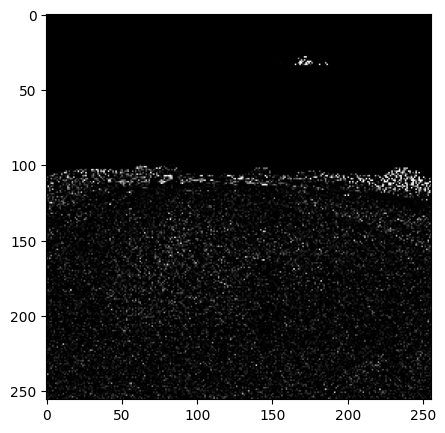

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 31,  15,   0, ...,   0,   0,   7],
       [  0,  22,  34, ...,   0,   0, 111],
       [ 32,  44,   0, ...,   4,   0,   0]], dtype=uint8)

In [ ]:
image = cv2.imread(r"C:\Users\Mayank\Desktop\Lane_det\test_images\PXL_20250227_093750088.jpg")
edges = simple_edge_detection(image)
print(edges.shape)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET().to(device)
model.load_state_dict(torch.load(r"C:\Users\Mayank\Desktop\Lane_det\segmentation_torch_unet.pth", map_location=device, weights_only=True))
model.eval()
 
region_of_interest(Image.fromarray(image) , model ,edges)

In [ ]:
from helper import trial
import os
for path in os.listdir("./test_images"):
    Img = cv2.imread(os.path.join("test_images",path))
    trial(Img)


NameError: name 'cv2' is not defined

In [15]:
import numpy as np
import cv2
import torch
from PIL import Image
from models import UNET, transform
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load model once
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET().to(device)
model.load_state_dict(torch.load(r"C:\Users\Mayank\Desktop\Lane_det\segmentation_torch_unet.pth", map_location=device, weights_only=True))
model.eval()

# Function to ensure image is RGB
def ensure_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[2] == 3 else image

def bil_filter(frame) :
    d = 13
    sigma_color = 100
    sigma_space =90
    return cv2.bilateralFilter(frame, d, sigma_color, sigma_space)
# Get segmentation mask from model
def get_segmentation_mask(frame):
    try:
        frame_rgb = ensure_rgb(frame)
        img = Image.fromarray(frame_rgb)
        final_img = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            mask = model(final_img)
        
        output = (mask > 0.5).squeeze(0).permute(1, 2, 0).cpu().numpy()
        count_0 = int(np.count_nonzero(output == 0)*0.85)

        iterator = 0
        for i in range(256):
            for j in range(256):
                if output[255-i][255-j][0]==0:
                    iterator+=1
                    if iterator>=count_0:
                        output[255-i][255-j][0] = 1
        return output
    except Exception as e:
        print(f"Error in segmentation mask: {e}")
        return np.ones((frame.shape[0], frame.shape[1]))

# Adaptive Canny Edge Detection
def adaptive_canny(frame):
    try:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
        edges = cv2.Canny(gray, threshold * 0.5, threshold)
        # edges = cv2.Canny(gray, 150, 300)
        return edges
    except Exception as e:
        print(f"Error in Canny edge detection: {e}")
        return np.zeros_like(frame)

# Dynamic Hough Line Transform
def detect_hough_lines(edges):
    try:
        minLineLength = max(50, edges.shape[0] // 10)
        maxLineGap = max(20, edges.shape[1] // 20)
        return cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=minLineLength, maxLineGap=maxLineGap)
    except Exception as e:
        print(f"Error in Hough Line detection: {e}")
        return None

def split_lines(lines, xmid):
    left_lines, right_lines = [], []
    
    # if lines is None:  # Handle None or empty input safely
    #     print("Warning: No lines detected!")
    #     return left_lines, right_lines

    # x_coords = [line[0][0] for line in lines]  # Extract x1 values

    # if x_coords is None:  # Ensure x_coords is not empty
    #     print("Warning: No valid x-coordinates found!")
    #     return left_lines, right_lines
    
    # x_coords.sort()  # Sort in place
    # xmid = x_coords[len(x_coords) // 2]  # Find the middle x-value
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 <= xmid:
            left_lines.append(line)
        else:
            right_lines.append(line)

    return left_lines, right_lines


# Fit a single line for each lane

def cluster_lines(lines, k_val=1):
    if lines is None or len(lines) == 0:
        print(" Warning: No lines found for clustering!")
        return []  # Return an empty list instead of causing an error

    line_features = np.array([
        [(x1 + x2) / 2, (y1 + y2) / 2, np.arctan2(y2 - y1, x2 - x1)] 
        for [[x1, y1, x2, y2]] in lines
    ])

    # Ensure at least k clusters exist
    k_val = min(k_val, len(lines))  # Prevent k > number of data points

    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init=10).fit(line_features)
    labels = kmeans.labels_

    clustered_lines = [
        [[int(np.mean([lines[i][0][j] for i in np.where(labels == idx)[0]])) for j in range(4)]]
        for idx in range(k_val)
    ]
    return clustered_lines


# Lane detection pipeline
# def lane_detection_pipeline(frame):
#     try:
#         frame_rgb = ensure_rgb(frame)
#         blu  rred_frame = cv2.bilateralFilter(frame_rgb)
#         mask = get_segmentation_mask(frame)
#         edges = adaptive_canny(blurred_frame)
#         mask_resized = cv2.resize(mask.astype(np.uint8), (edges.shape[1], edges.shape[0]), interpolation=cv2.INTER_NEAREST)
#         inverted_mask = 1 - mask_resized
#         edges = edges * inverted_mask
#         lines = detect_hough_lines(edges)
#         left_lines, right_lines = split_lines(lines, frame.shape[1])
#         left_lane = cluster_lines(left_lines)
#         right_lane = cluster_lines(right_lines)
#         return [left_lane, right_lane]
#     except Exception as e:
#         print(f"Error in lane detection pipeline: {e}")
#         return [None, None]

# Draw lines
def draw_lanes_and_arrow(frame, lines):
    try:
        if lines is None or len(lines) < 2:
            print("Not enough lines to draw midline arrow!")
            return frame

        # Draw individual lane lines
        for line in lines:
            y1, x1, y2, x2 = line[0]
            cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Compute midline starting point (centroid of first two lines)
        x_start = (lines[0][0][0] + lines[0][0][2] + lines[1][0][0] + lines[1][0][2]) // 4
        y_start = (lines[0][0][1] + lines[0][0][3] + lines[1][0][1] + lines[1][0][3]) // 4

        # Compute slopes of both lines
        def slope(x1, y1, x2, y2):
            if y2>y1 :
                return (y2 - y1) / (x2 - x1 + 1e-6)
            else :
                return -(y2 - y1) / (x2 - x1 + 1e-6)  # Avoid division by zero

        slope1 = slope(*lines[0][0])
        slope2 = slope(*lines[1][0])
        avg_slope = (slope1 + slope2) / 2

        # Compute lengths of both lines
        def line_length(x1, y1, x2, y2):
            return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        len1 = line_length(*lines[0][0])
        len2 = line_length(*lines[1][0])
        arrow_length = max(len1, len2)  # Use the longer lane length

        # Compute end point using the average slope and length
        dx = int(200 / np.sqrt(1 + avg_slope ** 2))
        dy = int(avg_slope * dx)

        x_end = x_start + dx
        y_end = y_start + dy

        # Adjust direction based on y_start and y_end
        cv2.arrowedLine(frame, (x_end, y_end), (x_start, y_start), (0, 0, 255), 3, tipLength=0.3)
        return frame  # Return modified frame

    except Exception as e:
        print(f"Error in drawing lanes: {e}")
        return frame  # Return original frame if error

def process_frame(frame):
    frame_rgb = ensure_rgb(frame)
    blurred_frame = bil_filter(frame_rgb)
    mask = get_segmentation_mask(frame)
    edges = adaptive_canny(blurred_frame)
    mask_resized = cv2.resize(mask.astype(np.uint8), (edges.shape[1], edges.shape[0]), interpolation=cv2.INTER_NEAREST)
    inverted_mask = 1 - mask_resized
    edges = edges * inverted_mask
    # return edges
    lines = detect_hough_lines(edges)

    if lines is None or len(lines) == 0:  
        print("No lines detected. Returning unprocessed frame.")
        return frame_rgb  # Return the original frame

    left_lines, right_lines = split_lines(lines, (edges.shape[1])//2)

    # Handle missing lane lines
    if not left_lines and right_lines:
        print("No left lines found. Using right lines for both lanes.")
        left_lines = right_lines
    elif not right_lines and left_lines:
        print("No right lines found. Using left lines for both lanes.")
        right_lines = left_lines
    elif not left_lines and not right_lines:
        print("No lane lines detected. Returning unprocessed frame.")
        return frame_rgb  # Return the original frame if no lanes detected

    left_lane = cluster_lines(left_lines)
    right_lane = cluster_lines(right_lines)

    if not left_lane or not right_lane:  
        print("No lane detected after clustering. Returning unprocessed frame.")
        return frame_rgb  # Return original frame if clustering fails

    clustered_lines = [left_lane[0], right_lane[0]]
    return draw_lanes_and_arrow(frame_rgb, clustered_lines)

def process_video(input_path, output_path):
    """Reads a video, processes each frame, and saves the output video in MP4 format."""
    
    # Open the input video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Could not open input video.")
        return
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Ensure FPS is valid
    if fps <= 0 or fps is None:
        fps = 30  # Default to 30 FPS if not detected

    # Define the codec and create VideoWriter object (H.264 encoding for MP4)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' is more reliable than 'avc1'
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    print(f"Processing video: {input_path}")
    print(f"Output will be saved as: {output_path} (FPS: {fps}, Resolution: {frame_width}x{frame_height})")

    frame_count = 0
    frame_id = 0  # To process every Nth frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print(f"Processed {frame_count} frames. End of video reached.")
            break  # Stop when video ends

        # Process every 2nd frame (adjustable)
        if frame_id % 10 == 0:
            try:
                processed_frame = process_frame(frame)  # Apply processing if possible
                if processed_frame is None:
                    print(f"Warning: No processed output at frame {frame_count}. Writing original frame.")
                    processed_frame = frame  # Use the original frame if processing fails
            except Exception as e:
                print(f"Error processing frame {frame_count}: {e}. Writing original frame instead.")
                processed_frame = frame  # Use original frame on error

            # cv2.imshow(f"{frame_count}", processed_frame)
            # print(type(processed_frame))
            out.write(processed_frame)  # Write frame to output
            # plt.imshow(processed_frame)
            # plt.show()
        frame_count += 1
        frame_id += 1  # Increment frame counter

        if frame_count % 50 == 0:
            print(f"Processed {frame_count} frames...")

    # Release resources
    cap.release()
    out.release()

    # Handle OpenCV GUI issues
    try:
        cv2.destroyAllWindows()
    except cv2.error:
        print("Skipping cv2.destroyAllWindows() due to missing GUI support.")

    print(" Video processing complete!")

# Run the script
if __name__ == "__main__":
    input_video = r"C:\Users\Mayank\Desktop\Lane_det\test1.mp4"  # Update with the correct path
    output_video = r"C:\Users\Mayank\Desktop\Lane_det\output4.mp4"
    process_video(input_video, output_video)
    # frame = cv2.imread(r"C:\Users\yagni\PythonProjects\Pathpal\Path_navigation\test_images\testimg_insti.jpg")
    # e = process_frame(frame)
    # # # Show both images side by side
    # # plt.figure(figsize=(10, 5))

    # # # First image (e)
    # # plt.subplot(1, 2, 1)
    # plt.imshow(e, cmap="gray")
    # # plt.title("Processed Image 1")
    # # plt.axis("off")

    # # # Second image (v)
    # # plt.subplot(1, 2, 2)
    # # plt.imshow(v, cmap="gray")
    # # plt.title("Processed Image 2")
    # # plt.axis("off")

    # plt.show()

Processing video: C:\Users\Mayank\Desktop\Lane_det\test1.mp4
Output will be saved as: C:\Users\Mayank\Desktop\Lane_det\output4.mp4 (FPS: 30.056885003062437, Resolution: 478x850)
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
Processed 50 frames...
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
Processed 100 frames...
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No right lines found. Using left lines for both lanes.
No ri